In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import zarr
import time
import netCDF4 as nc
import h5py

In [3]:
YG = np.load('inputs/ref/YG.npy')
XG = np.load('inputs/ref/XG.npy')
YC = np.load('inputs/ref/YC.npy')
XC = np.load('inputs/ref/XC.npy')
RF = np.load('inputs/ref/RF.npy')

IMF = nc.Dataset('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/2D/2D_2005_09C.nc')
y1 = np.argmin(abs(IMF['YG'] - YG[0]))
y2 = np.argmin(abs(IMF['YG'] - YG[-1]))
x1 = np.argmin(abs(IMF['XG'] - XG[0]%360))
x2 = np.argmin(abs(IMF['XG'] - XG[-1]%360))

In [4]:
icedraft = h5py.File('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/meta/ICEDRAFT_v8.mat')
icedraft = icedraft['Ice_Map'][y1:y2+1,x1:x2+1]

grid = h5py.File('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/meta/GRID_v8.mat')
bath = -grid['Depth'][:]
bath = bath[y1:y2+1,x1:x2+1] + icedraft
bath[bath==0] = np.nan
bath[bath<-2000] = np.nan

In [5]:
ISMIP6 = nc.Dataset('/data/SO2/SO24/ANDY/SOHI/Data/Obs_Climatology/ISMIP6/obs_temperature_1995-2017_8km_x_60m.nc')

In [6]:
ISMIP_T = np.asarray(ISMIP6['temperature'][:])
ISMIP_lat = np.asarray(ISMIP6['lat'][:])
ISMIP_lon = np.asarray(ISMIP6['lon'][:])


In [7]:
bed = nc.Dataset('/data/SO2/SO24/ANDY/SOHI/Data/Obs_Climatology/ISMIP6/bedmap2_8km.nc')
bed = np.asarray(bed['bed'][:])

In [8]:
X = ISMIP6['x'][:]/1e3
Y = ISMIP6['y'][:]/1e3

In [9]:
ISMIP6['z'][:]

masked_array(data=[  -30.,   -90.,  -150.,  -210.,  -270.,  -330.,  -390.,
                    -450.,  -510.,  -570.,  -630.,  -690.,  -750.,  -810.,
                    -870.,  -930.,  -990., -1050., -1110., -1170., -1230.,
                   -1290., -1350., -1410., -1470., -1530., -1590., -1650.,
                   -1710., -1770.],
             mask=False,
       fill_value=1e+20)

In [10]:
## 510m, 570m, 630m, 690m, 750m, 810

def get_ISMIP(lat, lon):
    i1 = (ISMIP_lat - lat)**2
    i2 = (ISMIP_lon - lon)**2
    i3 = i1 + i2
    where = np.where(i3 == i3.min())
    iy = where[0][0]
    ix = where[1][0]
    
    return ISMIP_T[8, iy, ix], ISMIP_T[9, iy, ix], ISMIP_T[10, iy, ix], ISMIP_T[11, iy, ix], ISMIP_T[12, iy, ix], ISMIP_T[13, iy, ix]

### Filter Particles: Keep particles from East of ASE & GL that do not experience a looped velocity field

In [26]:
test = zarr.open('outputs/R8_ASE_5min/thwaites.zarr')
test['temperature'].shape

(389790, 1096)

In [36]:
list(test.keys())

['I',
 'J',
 'K',
 'age',
 'lat',
 'lon',
 'obs',
 'salinity',
 'temperature',
 'time',
 'trajectory',
 'z']

In [48]:
( 365 * 10) - 10

3640

In [45]:
test['lat'][-101, 1091]

-72.70805878695444

In [11]:
### Velocity loop every 1 year. Particle tracers release every day for 1 year. 
### Velocity field loop when particle stop being releashed
data = zarr.open('outputs/R8_ASE_5min/thwaites.zarr', 'r')
reftime = data['time'][0]
print(reftime[364:367])

[ 86400.      0. -86400.]


In [12]:
## particles that originate from off shelf, then get onto shelf, then travel to ASE is classified as off-shelf
def process(data_path, IS, CS, East, stucked, off_shelf_lon_bound = None):
    IS = np.load(IS)
    CS = np.load(CS)
    East = np.load(East)
    stucked = np.load(stucked)
    
    data = zarr.open(data_path, 'r')
    
    flags = np.zeros(len(CS))
    
    if off_shelf_lon_bound is not None:
        n = 2 + len(off_shelf_lon_bound)
    else:
        n=2
    
    Tedge = [[] for i in range(n)]
    T73   = [[] for i in range(n)]
    T74   = [[] for i in range(n)]
    Tice  = [[] for i in range(n)]
    Tgl   = [[] for i in range(n)]
    
    
    I1_edge = [[] for i in range(n)]
    I1_73   = [[] for i in range(n)]
    I1_74   = [[] for i in range(n)]
    I1_ice  = [[] for i in range(n)]
    I1_gl   = [[] for i in range(n)]
    
    I2_edge = [[] for i in range(n)]
    I2_73   = [[] for i in range(n)]
    I2_74   = [[] for i in range(n)]
    I2_ice  = [[] for i in range(n)]
    I2_gl   = [[] for i in range(n)]
    
    I3_edge = [[] for i in range(n)]
    I3_73   = [[] for i in range(n)]
    I3_74   = [[] for i in range(n)]
    I3_ice  = [[] for i in range(n)]
    I3_gl   = [[] for i in range(n)]
    
    I4_edge = [[] for i in range(n)]
    I4_73   = [[] for i in range(n)]
    I4_74   = [[] for i in range(n)]
    I4_ice  = [[] for i in range(n)]
    I4_gl   = [[] for i in range(n)]
    
    I5_edge = [[] for i in range(n)]
    I5_73   = [[] for i in range(n)]
    I5_74   = [[] for i in range(n)]
    I5_ice  = [[] for i in range(n)]
    I5_gl   = [[] for i in range(n)]
    
    I6_edge = [[] for i in range(n)]
    I6_73   = [[] for i in range(n)]
    I6_74   = [[] for i in range(n)]
    I6_ice  = [[] for i in range(n)]
    I6_gl   = [[] for i in range(n)]
    
    print('Loading time...')
    time = np.asarray(data['time'][:])
    print('Loading lat...')
    lats = np.asarray(data['lat'][:])
    if off_shelf_lon_bound is not None:
        print('Loading lon...')
        lons = np.asarray(data['lon'][:])
    print('Loading temperature...')
    THETA = np.asarray(data['temperature'][:])
    
    
    for p in tqdm(range(len(CS))):
        if stucked[p] == 1:
            continue
            
        if ~np.isnan(East[p]) and np.isnan(CS[p]): ## East
            
            if time[p, int(East[p])] > 0:
                
                Tedge[0].append(THETA[p, int(East[p])])
                Tice[0].append(THETA[p, int(IS[p])])
                Tgl[0].append(THETA[p, 1])
                
                ## Get ISMIP6: East
                lat = lats[p, int(East[p])]
                lon = lons[p, int(East[p])]
                
                z1, z2, z3, z4, z5, z6 = get_ISMIP(lat, lon)
                
                I1_edge[0].append(z1)
                I2_edge[0].append(z2)
                I3_edge[0].append(z3)
                I4_edge[0].append(z4)
                I5_edge[0].append(z5)
                I6_edge[0].append(z6)
                        
                ## Get ISMIP6: IS
                lat = lats[p, int(IS[p])]
                lon = lons[p, int(IS[p])]
                
                z1, z2, z3, z4, z5, z6 = get_ISMIP(lat, lon)
                
                I1_ice[0].append(z1)
                I2_ice[0].append(z2)
                I3_ice[0].append(z3)
                I4_ice[0].append(z4)
                I5_ice[0].append(z5)
                I6_ice[0].append(z6)
                
                ## Get ISMIP6: GL
                lat = lats[p, 1]
                lon = lons[p, 1]
                
                z1, z2, z3, z4, z5, z6 = get_ISMIP(lat, lon)
                
                I1_gl[0].append(z1)
                I2_gl[0].append(z2)
                I3_gl[0].append(z3)
                I4_gl[0].append(z4)
                I5_gl[0].append(z5)
                I6_gl[0].append(z6)
                
                flag = False
                
                for t in range(int(IS[p]), int(East[p])):
                    if not flag:
                        if lats[p, t] > -74:
                            
                            T74[0].append(THETA[p, t])
                            
                            lat = lats[p, t]
                            lon = lons[p, t]
                            z1, z2, z3, z4, z5, z6 = get_ISMIP(lat, lon)
                            
                            I1_74[0].append(z1)
                            I2_74[0].append(z2)
                            I3_74[0].append(z3)
                            I4_74[0].append(z4)
                            I5_74[0].append(z5)
                            I6_74[0].append(z6)
                            
                            flag = True
                            
                    else:
                        if lats[p, t] > -73:
                            
                            T73[0].append(THETA[p, t])
                            
                            lat = lats[p, t]
                            lon = lons[p, t]
                            z1, z2, z3, z4, z5, z6 = get_ISMIP(lat, lon)
                            
                            I1_73[0].append(z1)
                            I2_73[0].append(z2)
                            I3_73[0].append(z3)
                            I4_73[0].append(z4)
                            I5_73[0].append(z5)
                            I6_73[0].append(z6)
                            break

    
        
        elif ~np.isnan(CS[p]): ## off-shelf

            if time[p, int(CS[p])] > 0:
                
                nindex = None
                
                if off_shelf_lon_bound is not None:
                    ll = lons[p, int(CS[p])]
                    
                    for lb in range(len(off_shelf_lon_bound)):
                        lb1 = off_shelf_lon_bound[lb][0]
                        lb2 = off_shelf_lon_bound[lb][1]
                        
                        if ll < lb1 or ll > lb2:
                            nindex = lb+2
                
                Tedge[1].append(THETA[p, int(CS[p])])
                Tice[1].append(THETA[p, int(IS[p])])
                Tgl[1].append(THETA[p, 1])
                
                if nindex is not None:
                    Tedge[nindex].append(THETA[p, int(CS[p])])
                    Tice[nindex].append(THETA[p, int(IS[p])])
                    Tgl[nindex].append(THETA[p, 1])
                
                
                ## Get ISMIP6
                lat = lats[p, int(CS[p])]
                lon = lons[p, int(CS[p])]
                
                z1, z2, z3, z4, z5, z6 = get_ISMIP(lat, lon)
                
                I1_edge[1].append(z1)
                I2_edge[1].append(z2)
                I3_edge[1].append(z3)
                I4_edge[1].append(z4)
                I5_edge[1].append(z5)
                I6_edge[1].append(z6)
                
                if nindex is not None:
                    I1_edge[nindex].append(z1)
                    I2_edge[nindex].append(z2)
                    I3_edge[nindex].append(z3)
                    I4_edge[nindex].append(z4)
                    I5_edge[nindex].append(z5)
                    I6_edge[nindex].append(z6)
                        
                ## Get ISMIP6: IS
                lat = lats[p, int(IS[p])]
                lon = lons[p, int(IS[p])]
                
                z1, z2, z3, z4, z5, z6 = get_ISMIP(lat, lon)
                
                I1_ice[1].append(z1)
                I2_ice[1].append(z2)
                I3_ice[1].append(z3)
                I4_ice[1].append(z4)
                I5_ice[1].append(z5)
                I6_ice[1].append(z6)
                
                if nindex is not None:
                    I1_ice[nindex].append(z1)
                    I2_ice[nindex].append(z2)
                    I3_ice[nindex].append(z3)
                    I4_ice[nindex].append(z4)
                    I5_ice[nindex].append(z5)
                    I6_ice[nindex].append(z6)
                
                ## Get ISMIP6: GL
                lat = lats[p, 1]
                lon = lons[p, 1]
                
                z1, z2, z3, z4, z5, z6 = get_ISMIP(lat, lon)
                
                I1_gl[1].append(z1)
                I2_gl[1].append(z2)
                I3_gl[1].append(z3)
                I4_gl[1].append(z4)
                I5_gl[1].append(z5)
                I6_gl[1].append(z6)
                
                if nindex is not None:
                    I1_gl[nindex].append(z1)
                    I2_gl[nindex].append(z2)
                    I3_gl[nindex].append(z3)
                    I4_gl[nindex].append(z4)
                    I5_gl[nindex].append(z5)
                    I6_gl[nindex].append(z6)
                
                
                ##############
                flag = False
                
                for t in range(int(IS[p]), int(CS[p])):
                    if not flag:
                        if lats[p, t] > -74:
                            
                            T74[1].append(THETA[p, t])
                            if nindex is not None:
                                T74[nindex].append(THETA[p, t])
                            
                            lat = lats[p, t]
                            lon = lons[p, t]
                            z1, z2, z3, z4, z5, z6 = get_ISMIP(lat, lon)
                            
                            I1_74[1].append(z1)
                            I2_74[1].append(z2)
                            I3_74[1].append(z3)
                            I4_74[1].append(z4)
                            I5_74[1].append(z5)
                            I6_74[1].append(z6)
                            
                            if nindex is not None:
                                I1_74[nindex].append(z1)
                                I2_74[nindex].append(z2)
                                I3_74[nindex].append(z3)
                                I4_74[nindex].append(z4)
                                I5_74[nindex].append(z5)
                                I6_74[nindex].append(z6)
                            
                            flag = True
                            
                    else:
                        if lats[p, t] > -73:
                            
                            T73[1].append(THETA[p, t])
                            if nindex is not None:
                                T73[nindex].append(THETA[p, t])
                                
                            lat = lats[p, t]
                            lon = lons[p, t]
                            z1, z2, z3, z4, z5, z6 = get_ISMIP(lat, lon)
                            
                            I1_73[1].append(z1)
                            I2_73[1].append(z2)
                            I3_73[1].append(z3)
                            I4_73[1].append(z4)
                            I5_73[1].append(z5)
                            I6_73[1].append(z6)
                                                        
                            if nindex is not None:
                                I1_73[nindex].append(z1)
                                I2_73[nindex].append(z2)
                                I3_73[nindex].append(z3)
                                I4_73[nindex].append(z4)
                                I5_73[nindex].append(z5)
                                I6_73[nindex].append(z6)
                                
                            break
                        
                        
    return np.asarray(Tedge), np.asarray(T73), np.asarray(T74), np.asarray(Tice), np.asarray(Tgl), \
np.asarray(I1_edge), np.asarray(I1_73), np.asarray(I1_74), np.asarray(I1_ice), np.asarray(I1_gl), \
np.asarray(I2_edge), np.asarray(I2_73), np.asarray(I2_74), np.asarray(I2_ice), np.asarray(I2_gl), \
np.asarray(I3_edge), np.asarray(I3_73), np.asarray(I3_74), np.asarray(I3_ice), np.asarray(I3_gl), \
np.asarray(I4_edge), np.asarray(I4_73), np.asarray(I4_74), np.asarray(I4_ice), np.asarray(I4_gl), \
np.asarray(I5_edge), np.asarray(I5_73), np.asarray(I5_74), np.asarray(I5_ice), np.asarray(I5_gl), \
np.asarray(I6_edge), np.asarray(I6_73), np.asarray(I6_74), np.asarray(I6_ice), np.asarray(I6_gl)

In [13]:
PIGE, PIG73, PIG74, PIGICE, PIGGL, \
PIGI1_E, PIGI1_73, PIGI1_74, PIGI1_ICE, PIGI1_GL, \
PIGI2_E, PIGI2_73, PIGI2_74, PIGI2_ICE, PIGI2_GL, \
PIGI3_E, PIGI3_73, PIGI3_74, PIGI3_ICE, PIGI3_GL, \
PIGI4_E, PIGI4_73, PIGI4_74, PIGI4_ICE, PIGI4_GL, \
PIGI5_E, PIGI5_73, PIGI5_74, PIGI5_ICE, PIGI5_GL, \
PIGI6_E, PIGI6_73, PIGI6_74, PIGI6_ICE, PIGI6_GL = process(data_path = 'outputs/R8_ASE_5min/pineisland.zarr',
                                            IS = 'processed_dataGL/pineisland_0d_IS.npy',
                                            CS = 'processed_dataGL/pineisland_0d_CS.npy',
                                            East = 'processed_dataGL/pineisland_0d_Eastern.npy',
                                            stucked = 'processed_dataGL/pineisland_0d_Stucked.npy',
                                            off_shelf_lon_bound = [[-106.2, -104.5],
                                                                   [-104.5, -101]])

Loading time...
Loading lat...
Loading lon...
Loading temperature...


100%|█████████████████████████████████| 397476/397476 [02:13<00:00, 2988.33it/s]
/tmp/ipykernel_293332/3841815844.py:313: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(Tedge), np.asarray(T73), np.asarray(T74), np.asarray(Tice), np.asarray(Tgl), \
/tmp/ipykernel_293332/3841815844.py:314: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(I1_edge), np.asarray(I1_73), np.asarray(I1_74), np.asarray(I1_ice), np.asarray(I1_gl), \
/tmp/ipykernel_293332/3841815844.py:315: VisibleDeprecationWarning: Creating an ndarray from ragged nest

In [14]:
THWE, THW73, THW74, THWICE, THWGL, \
THWI1_E, THWI1_73, THWI1_74, THWI1_ICE, THWI1_GL, \
THWI2_E, THWI2_73, THWI2_74, THWI2_ICE, THWI2_GL, \
THWI3_E, THWI3_73, THWI3_74, THWI3_ICE, THWI3_GL, \
THWI4_E, THWI4_73, THWI4_74, THWI4_ICE, THWI4_GL, \
THWI5_E, THWI5_73, THWI5_74, THWI5_ICE, THWI5_GL, \
THWI6_E, THWI6_73, THWI6_74, THWI6_ICE, THWI6_GL = process(data_path = 'outputs/R8_ASE_5min/thwaites.zarr',
                                            IS = 'processed_dataGL/thwaites_0d_IS.npy',
                                            CS = 'processed_dataGL/thwaites_0d_CS.npy',
                                            East = 'processed_dataGL/thwaites_0d_Eastern.npy',
                                            stucked = 'processed_dataGL/thwaites_0d_Stucked.npy',
                                            off_shelf_lon_bound = [[-106.2, -104.5],
                                                                   [-104.5, -101]])

Loading time...
Loading lat...
Loading lon...
Loading temperature...


100%|█████████████████████████████████| 389790/389790 [00:55<00:00, 7057.78it/s]
/tmp/ipykernel_293332/3841815844.py:313: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(Tedge), np.asarray(T73), np.asarray(T74), np.asarray(Tice), np.asarray(Tgl), \
/tmp/ipykernel_293332/3841815844.py:314: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(I1_edge), np.asarray(I1_73), np.asarray(I1_74), np.asarray(I1_ice), np.asarray(I1_gl), \
/tmp/ipykernel_293332/3841815844.py:315: VisibleDeprecationWarning: Creating an ndarray from ragged nest

In [15]:
SMTE, SMT73, SMT74, SMTICE, SMTGL, \
SMTI1_E, SMTI1_73, SMTI1_74, SMTI1_ICE, SMTI1_GL, \
SMTI2_E, SMTI2_73, SMTI2_74, SMTI2_ICE, SMTI2_GL, \
SMTI3_E, SMTI3_73, SMTI3_74, SMTI3_ICE, SMTI3_GL, \
SMTI4_E, SMTI4_73, SMTI4_74, SMTI4_ICE, SMTI4_GL, \
SMTI5_E, SMTI5_73, SMTI5_74, SMTI5_ICE, SMTI5_GL, \
SMTI6_E, SMTI6_73, SMTI6_74, SMTI6_ICE, SMTI6_GL = process(data_path = 'outputs/R8_ASE_5min/smith.zarr',
                                            IS = 'processed_dataGL/smith_0d_IS.npy',
                                            CS = 'processed_dataGL/smith_0d_CS.npy',
                                            East = 'processed_dataGL/smith_0d_Eastern.npy',
                                            stucked = 'processed_dataGL/smith_0d_Stucked.npy',
                                            off_shelf_lon_bound = [[-121, -116],
                                                                   [-114.5, -113]])

Loading time...
Loading lat...
Loading lon...
Loading temperature...


100%|█████████████████████████████████| 376980/376980 [02:17<00:00, 2746.85it/s]
/tmp/ipykernel_293332/3841815844.py:313: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(Tedge), np.asarray(T73), np.asarray(T74), np.asarray(Tice), np.asarray(Tgl), \
/tmp/ipykernel_293332/3841815844.py:314: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(I1_edge), np.asarray(I1_73), np.asarray(I1_74), np.asarray(I1_ice), np.asarray(I1_gl), \
/tmp/ipykernel_293332/3841815844.py:315: VisibleDeprecationWarning: Creating an ndarray from ragged nest

In [16]:
KHLE, KHL73, KHL74, KHLICE, KHLGL, \
KHLI1_E, KHLI1_73, KHLI1_74, KHLI1_ICE, KHLI1_GL, \
KHLI2_E, KHLI2_73, KHLI2_74, KHLI2_ICE, KHLI2_GL, \
KHLI3_E, KHLI3_73, KHLI3_74, KHLI3_ICE, KHLI3_GL, \
KHLI4_E, KHLI4_73, KHLI4_74, KHLI4_ICE, KHLI4_GL, \
KHLI5_E, KHLI5_73, KHLI5_74, KHLI5_ICE, KHLI5_GL, \
KHLI6_E, KHLI6_73, KHLI6_74, KHLI6_ICE, KHLI6_GL = process(data_path = 'outputs/R8_ASE_5min/kohler.zarr',
                                            IS = 'processed_dataGL/kohler_0d_IS.npy',
                                            CS = 'processed_dataGL/kohler_0d_CS.npy',
                                            East = 'processed_dataGL/kohler_0d_Eastern.npy',
                                            stucked = 'processed_dataGL/kohler_0d_Stucked.npy',
                                            off_shelf_lon_bound = [[-121, -116],
                                                                   [-114.5, -113]])

Loading time...
Loading lat...
Loading lon...
Loading temperature...


100%|█████████████████████████████████| 365268/365268 [02:22<00:00, 2567.97it/s]
/tmp/ipykernel_293332/3841815844.py:313: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(Tedge), np.asarray(T73), np.asarray(T74), np.asarray(Tice), np.asarray(Tgl), \
/tmp/ipykernel_293332/3841815844.py:314: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(I1_edge), np.asarray(I1_73), np.asarray(I1_74), np.asarray(I1_ice), np.asarray(I1_gl), \
/tmp/ipykernel_293332/3841815844.py:315: VisibleDeprecationWarning: Creating an ndarray from ragged nest

In [17]:
def get(data):
    res = data.copy()
    res[res== 0] = np.nan
    return np.nanmean(res), np.nanstd(res)

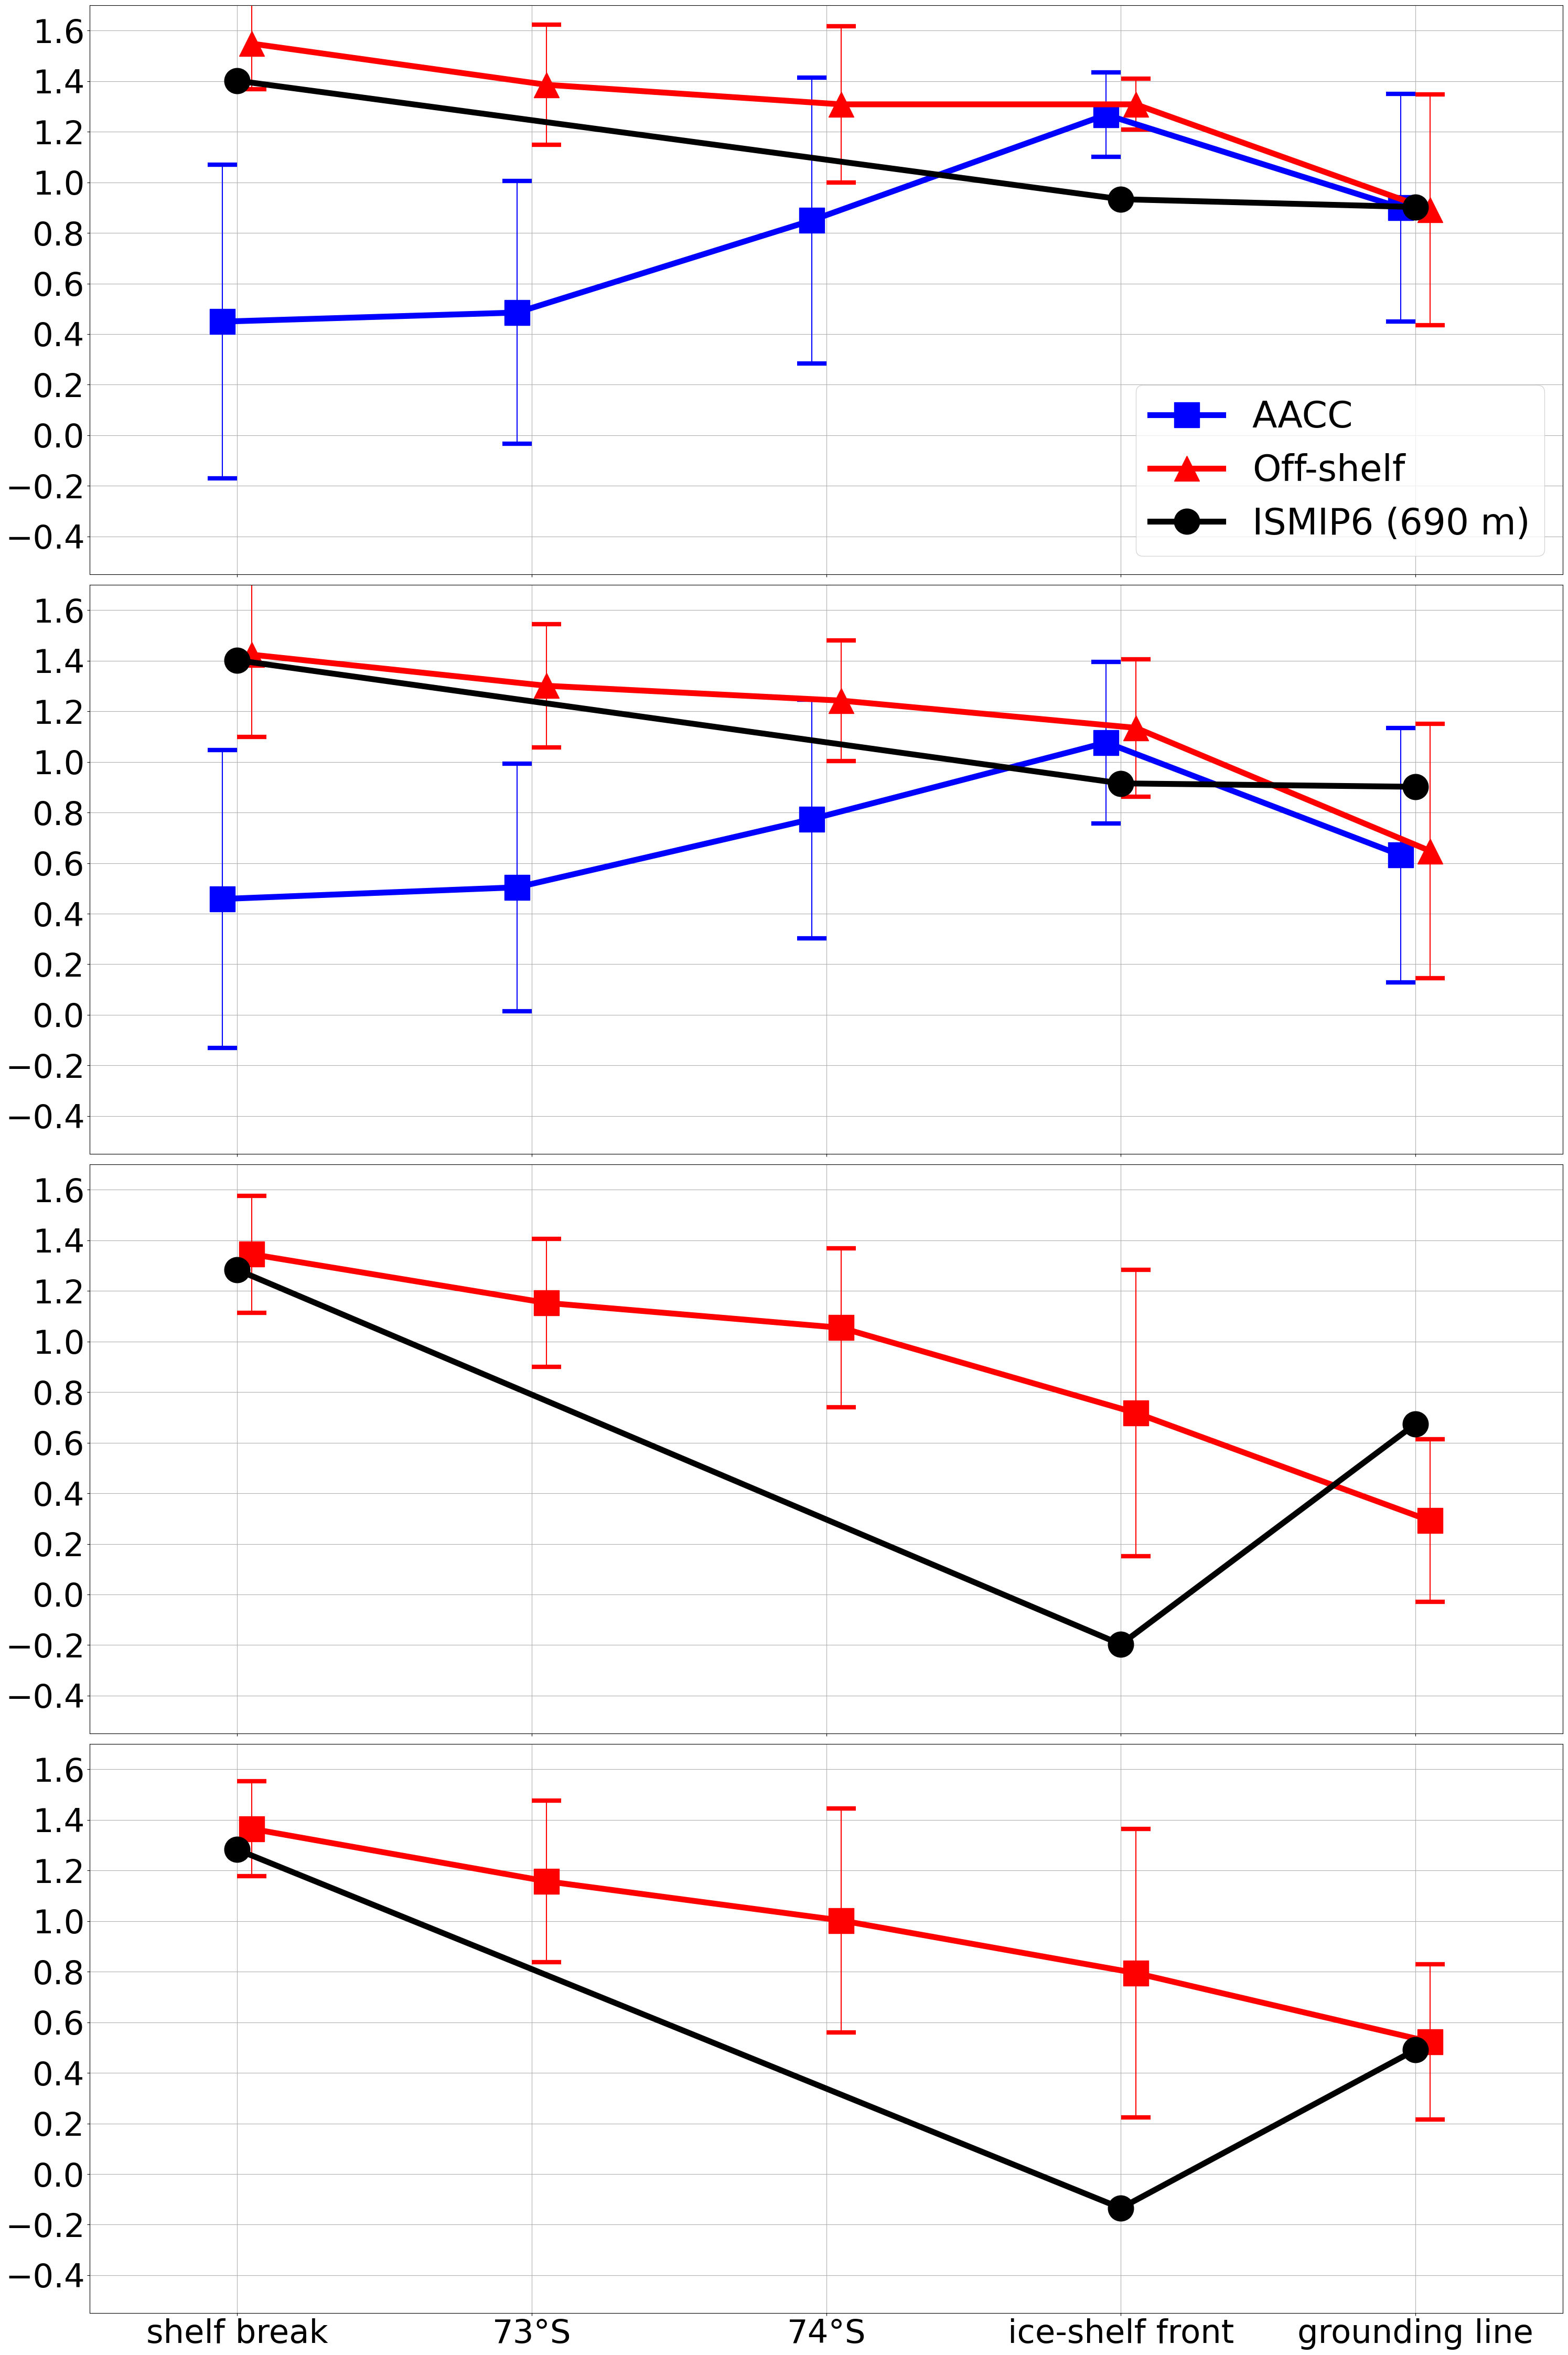

In [25]:
fig, ax = plt.subplots(figsize=(30, 45), nrows=4, sharex=True)

### PINE ISLAND

val = np.asarray([get(PIGE[0]), get(PIG73[0]), 
       get(PIG74[0]), get(PIGICE[0]), get(PIGGL[0])])
ax[0].errorbar([0.95, 1.95, 2.95, 3.95, 4.95],val[:,0], yerr= val[:,1], capsize=20, capthick=6, ecolor='blue',ls='none')
ax[0].plot([0.95, 1.95, 2.95, 3.95, 4.95], val[:,0], marker='s', markersize=35, zorder=3, lw=8, c='blue', label='AACC')


val = np.asarray([get(PIGE[1]), get(PIG73[1]), get(PIG74[1]), get(PIGICE[1]), get(PIGGL[1])])
ax[0].errorbar([1.05,2.05,3.05,4.05,5.05],val[:,0], yerr= val[:,1], capsize=20, capthick=6, ecolor='red', ls='none')
ax[0].plot([1.05,2.05,3.05,4.05,5.05], val[:,0], marker='^', markersize=35, zorder=3, lw=8, c='red', label='Off-shelf')

val = np.asarray([get(PIGI4_E[1]), get(PIGI4_ICE[1]), get(PIGI4_GL[1])])
ax[0].plot([1,4,5] ,val[:,0], '-', color='k',lw=8, marker='o', markersize=35, label='ISMIP6 (690 m)', zorder=3)


### THWAITES

val = np.asarray([get(THWE[0]), get(THW73[0]), 
       get(THW74[0]), get(THWICE[0]), get(THWGL[0])])
ax[1].errorbar([0.95, 1.95, 2.95, 3.95, 4.95],val[:,0], yerr= val[:,1], capsize=20, capthick=6, ecolor='blue',ls='none')
ax[1].plot([0.95, 1.95, 2.95, 3.95, 4.95], val[:,0], marker='s', markersize=35, zorder=3, lw=8, c='blue', label='East-shelf')

val = np.asarray([get(THWE[1]), get(THW73[1]), get(THW74[1]), get(THWICE[1]), get(THWGL[1])])
ax[1].errorbar([1.05,2.05,3.05,4.05,5.05],val[:,0], yerr= val[:,1], capsize=20, capthick=6, ecolor='red', ls='none')
ax[1].plot([1.05,2.05,3.05,4.05,5.05], val[:,0], marker='^', markersize=35, zorder=3, lw=8, c='red', label='Off-shelf')

val = np.asarray([get(THWI4_E[1]), get(THWI4_ICE[1]), get(THWI4_GL[1])])
ax[1].plot([1,4,5] ,val[:,0], '-', color='k',lw=8, marker='o', markersize=35, label='ISMIP6 (690 m)', zorder=3)


### Smith
val = np.asarray([get(SMTE[1]), get(SMT73[1]), get(SMT74[1]), get(SMTICE[1]), get(SMTGL[1])])
ax[2].errorbar([1.05,2.05,3.05,4.05,5.05],val[:,0], yerr= val[:,1], capsize=20, capthick=6, ecolor='red',ls='none')
ax[2].plot([1.05,2.05,3.05,4.05,5.05], val[:,0], marker='s', markersize=35, zorder=3, lw=8, c='red', label='Off-shelf')

val = np.asarray([get(SMTI4_E[1]), get(SMTI4_ICE[1]), get(SMTI4_GL[1])])
ax[2].plot([1,4,5] ,val[:,0], '-', color='k',lw=8, marker='o', markersize=35, label='ISMIP6 (690 m)', zorder=3)


### Kohler

val = np.asarray([get(KHLE[1]), get(KHL73[1]), get(KHL74[1]), get(KHLICE[1]), get(KHLGL[1])])
ax[3].errorbar([1.05,2.05,3.05,4.05,5.05],val[:,0], yerr= val[:,1], capsize=20, capthick=6, ecolor='red',ls='none')
ax[3].plot([1.05,2.05,3.05,4.05,5.05], val[:,0], marker='s', markersize=35, zorder=3, lw=8, c='red', label='Off-shelf')

val = np.asarray([get(KHLI4_E[1]), get(KHLI4_ICE[1]), get(KHLI4_GL[1])])
ax[3].plot([1,4,5] ,val[:,0], '-', color='k',lw=8, marker='o', markersize=35, label='ISMIP6 (690 m)', zorder=3)



for a in ax.flat:
    a.grid()
    a.set_ylim(-0.55, 1.7)
    a.tick_params(axis='both', labelsize=45)
    a.set_yticks(np.arange(-0.4, 1.61, 0.2))
#     a.set_yticklabels([None, 0.2, None, 0.4, None, 0.6, None, 0.8, None, "1.0", None, 1.2, None, 1.4, None,
#                       1.6, None, 1.8, None, 2.0])
    
    a.set_xlim(0.5, 5.5)
    a.set_xticks([1,2,3,4,5])
    a.set_xticklabels(['shelf break', '73°S', '74°S', 'ice-shelf front', 'grounding line'])

ax[0].legend(fontsize=50, loc='lower right', markerscale = 1.0)

plt.tight_layout()

plt.savefig('img_heattransfer/ALL.png', dpi=300)

In [72]:
cmap = plt.get_cmap('viridis_r', 4)

In [65]:
cmap(0)

(0.267004, 0.004874, 0.329415, 1.0)

In [54]:
mask = np.load('/data/SO2/SO24/ANDY/SOHI/Notebooks/1_SOHI_Eval/07_ISMIP_Comparison/maps/ICESHELVES.npy')

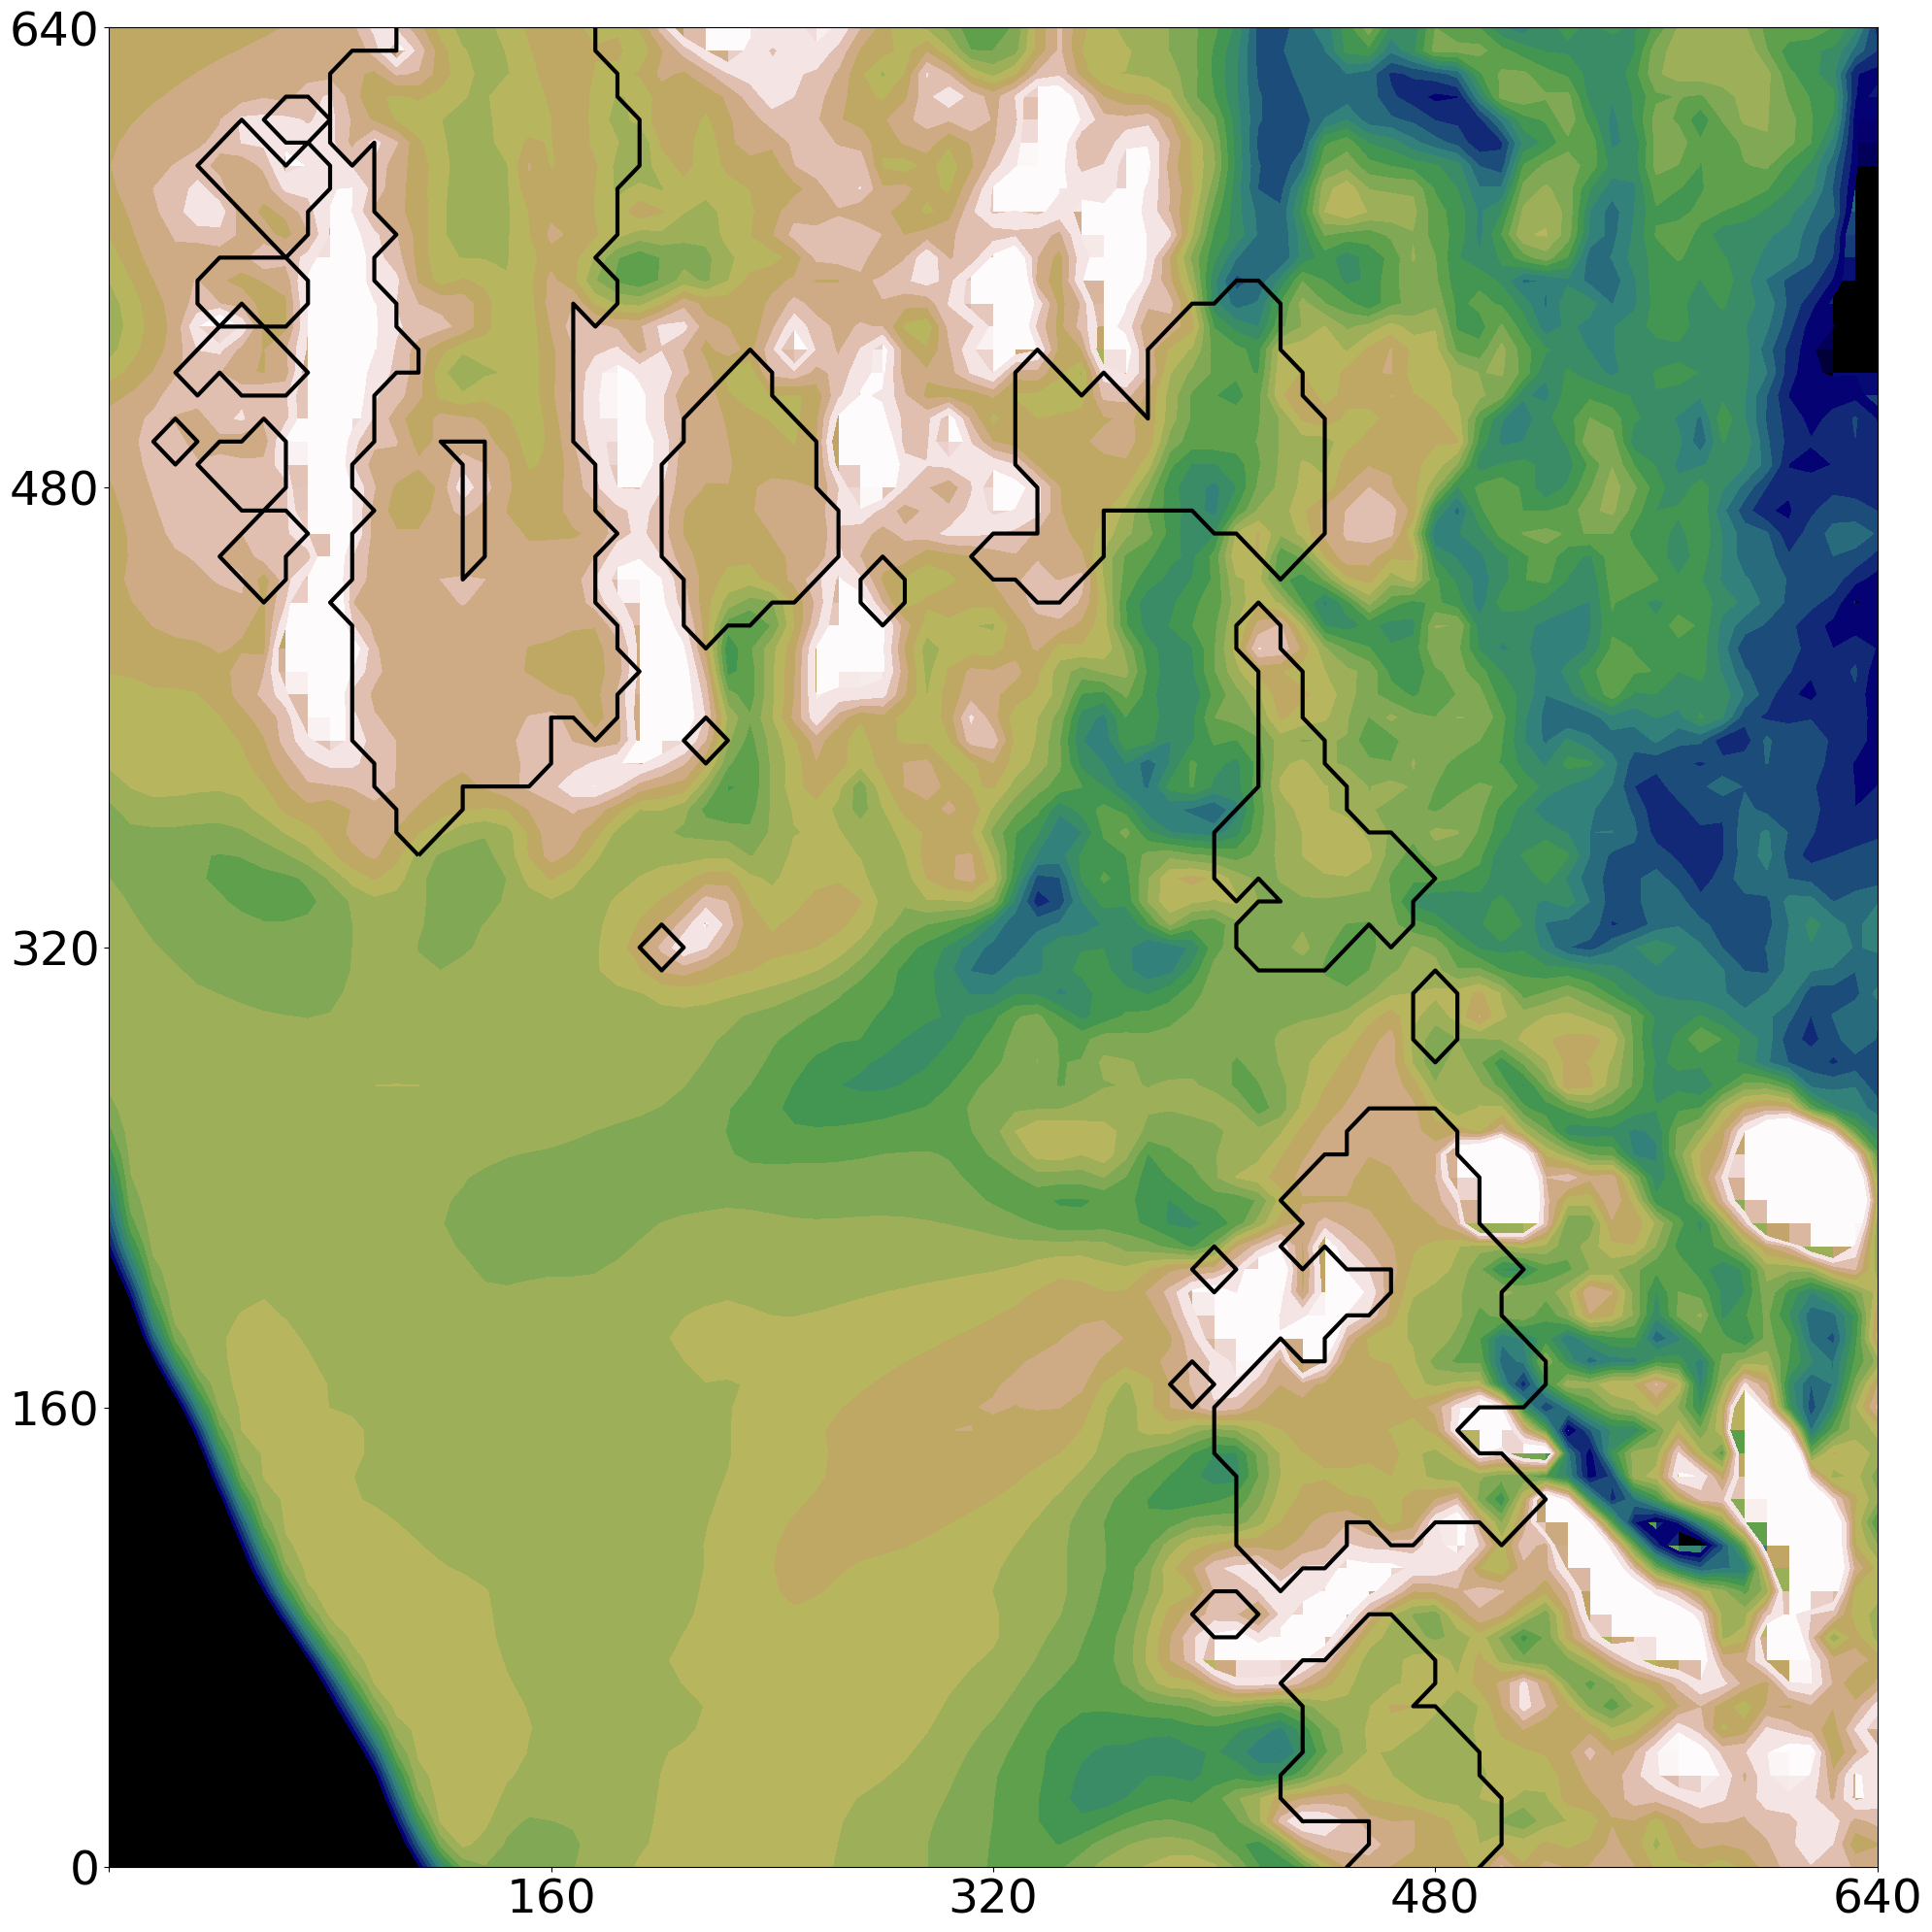

In [189]:
fig, ax = plt.subplots(figsize=(20,20))
im1 = ax.pcolormesh(bed, vmin=-1501, vmax=0, cmap='gist_earth')
im2 = ax.contourf(bed, levels=np.arange(-1500, 1, 100), cmap='gist_earth')
ax.contour(mask, levels=[0,1], colors=['k'], linestyles='solid', linewidths=3)

ax.set_xlim(130, 210)
ax.set_ylim(280, 360)
    
ax.set_xticks([130, 150, 170, 190, 210])
ax.set_xticklabels([None, 160, 320, 480, 640])
    
ax.set_yticks([280, 300, 320, 340, 360])
ax.set_yticklabels([0, 160, 320, 480, 640])
    
ax.tick_params(axis='both', labelsize=35)

plt.tight_layout()

plt.savefig('img_heattransfer/ISMIP_bed.png', dpi=300)

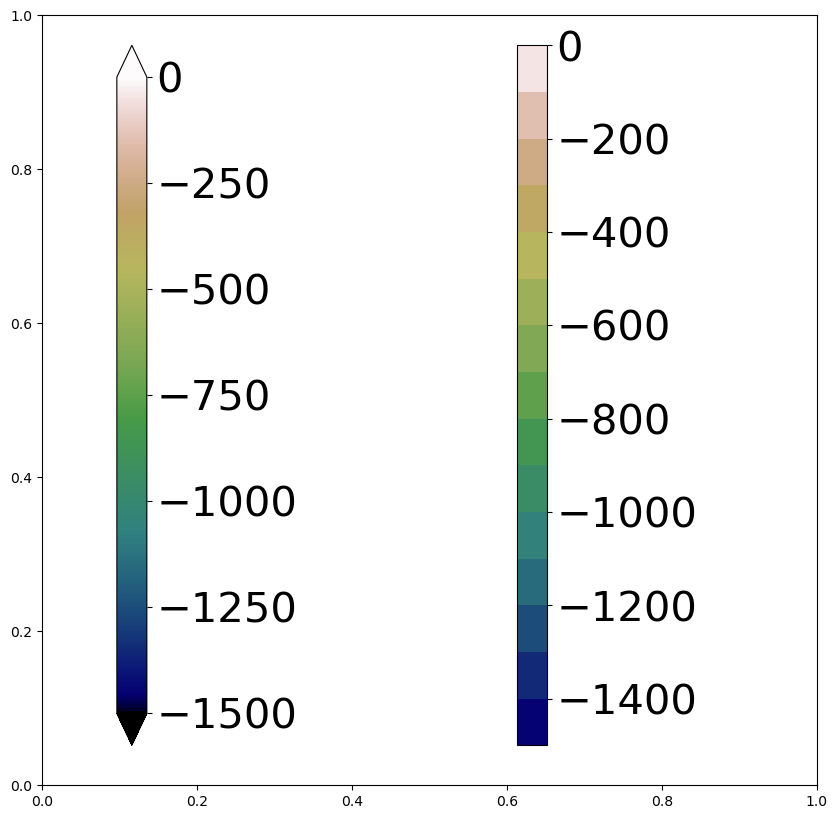

In [188]:
fig, ax = plt.subplots(figsize=(10,10))

cbar_ax = fig.add_axes([0.2, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im1, cax=cbar_ax,orientation='vertical', extend='both')
cbar.ax.set_ylabel(f'', size=30)
cbar.ax.tick_params(labelsize=30)
cbar_ax.yaxis.set_label_position("left")


cbar_ax = fig.add_axes([0.6, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im2, cax=cbar_ax,orientation='vertical', extend='both')
cbar.ax.set_ylabel(f'', size=30)
cbar.ax.tick_params(labelsize=30)
cbar_ax.yaxis.set_label_position("left")

plt.savefig('img_heattransfer/ISMIP_bed_cbar.png', dpi=300)

In [62]:
ISMIP6['z'][9]

masked_array(data=-570.,
             mask=False,
       fill_value=1e+20)

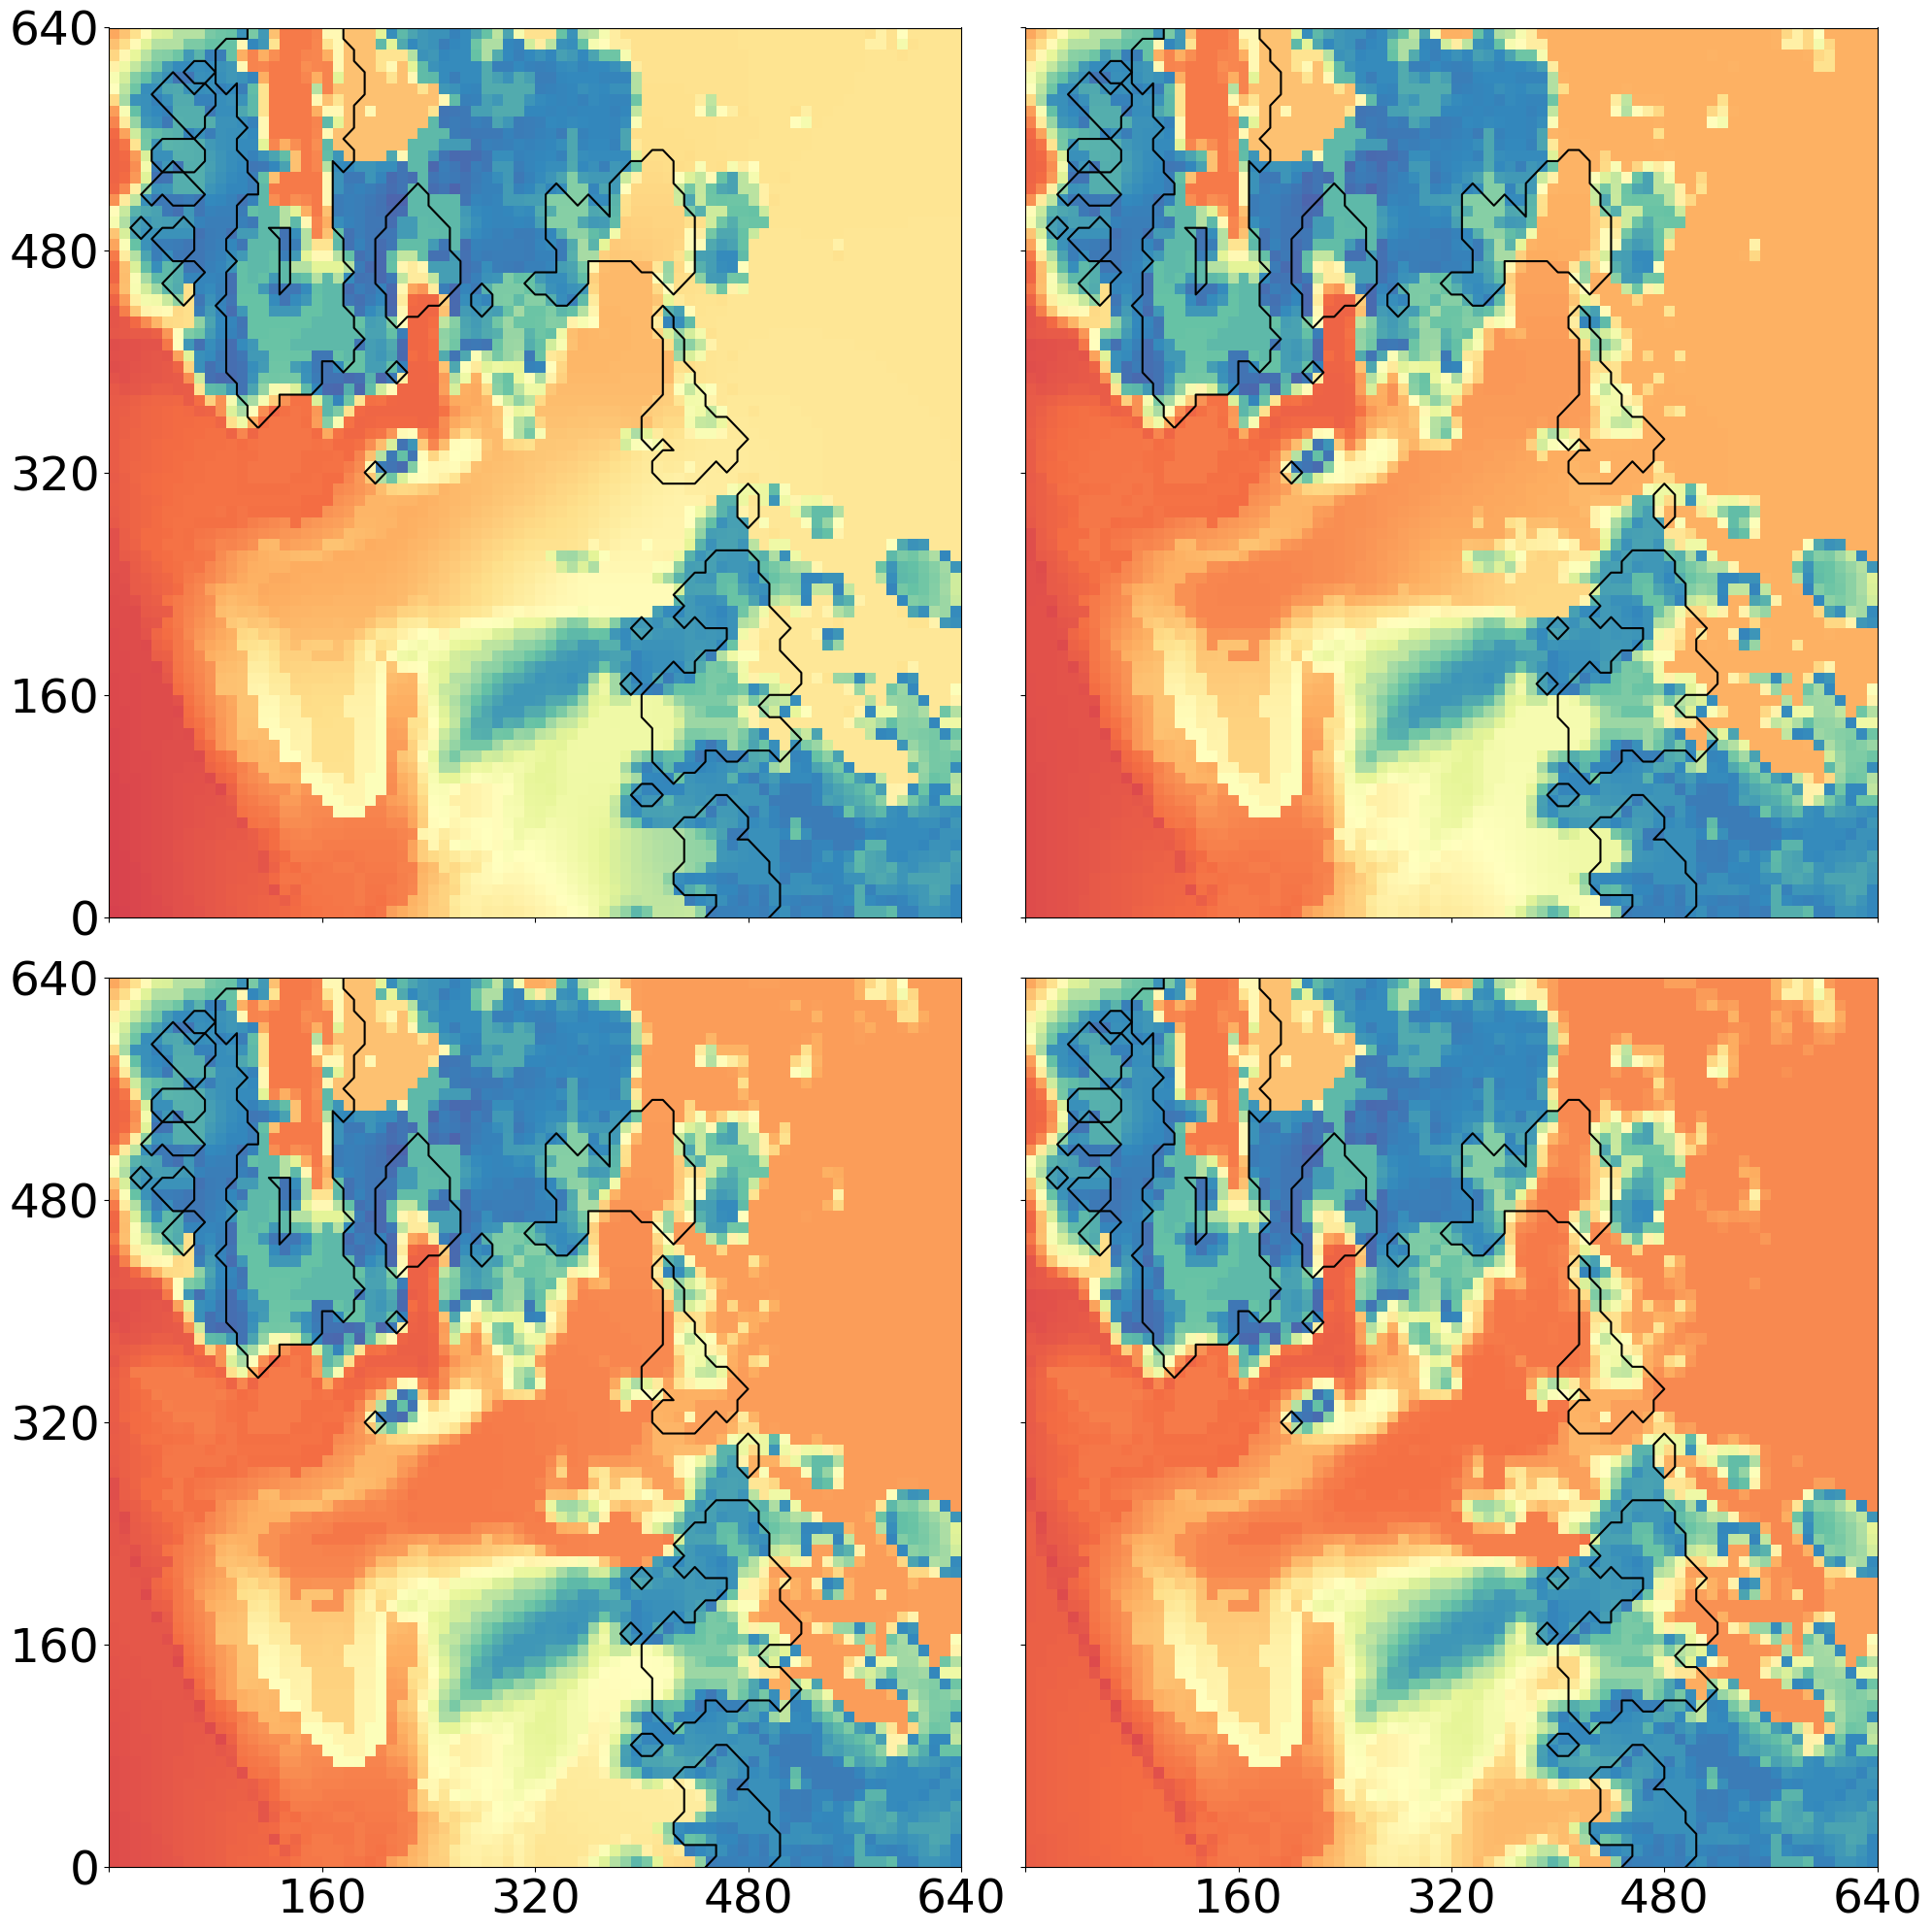

In [63]:
fig, ax = plt.subplots(figsize=(20,20), nrows=2, ncols=2, sharex=True, sharey=True)

im = ax[0,0].pcolormesh(ISMIP_T[9], vmin=-2, vmax=2, cmap='Spectral_r')
ax[0,0].contour(mask, levels=[0,1], colors=['k'], linestyles='solid')

ax[0,1].pcolormesh(ISMIP_T[10], vmin=-2, vmax=2, cmap='Spectral_r')
ax[0,1].contour(mask, levels=[0,1], colors=['k'], linestyles='solid')

ax[1,0].pcolormesh(ISMIP_T[11], vmin=-2, vmax=2, cmap='Spectral_r')
ax[1,0].contour(mask, levels=[0,1], colors=['k'], linestyles='solid')

ax[1,1].pcolormesh(ISMIP_T[14], vmin=-2, vmax=2, cmap='Spectral_r')
ax[1,1].contour(mask, levels=[0,1], colors=['k'], linestyles='solid')


for a in ax.flat:
    a.set_xlim(130, 210)
    a.set_ylim(280, 360)
    
    a.set_xticks([130, 150, 170, 190, 210])
    a.set_xticklabels([None, 160, 320, 480, 640])
    
    a.set_yticks([280, 300, 320, 340, 360])
    a.set_yticklabels([0, 160, 320, 480, 640])
    
    a.tick_params(axis='both', labelsize=35)
    
plt.tight_layout()

plt.savefig('img_heattransfer/ISMIP_map.png', dpi=300)

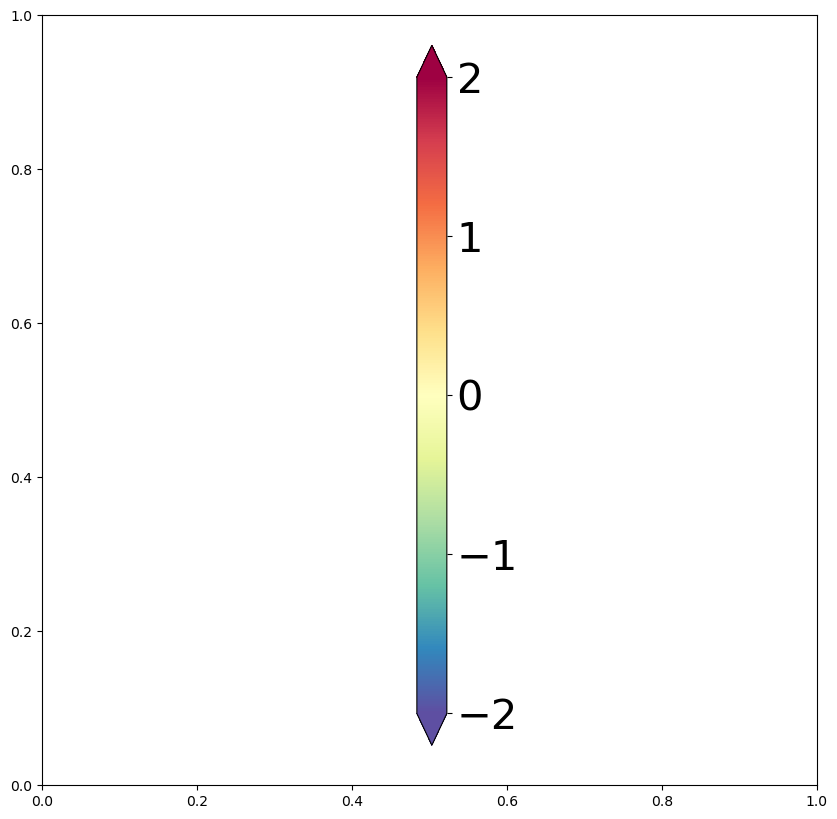

In [162]:
fig, ax = plt.subplots(figsize=(10,10))

cbar_ax = fig.add_axes([0.5, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='vertical', extend='both')
cbar.ax.set_ylabel(f'', size=30)
cbar.ax.tick_params(labelsize=30)
cbar_ax.yaxis.set_label_position("left")

plt.savefig('img_heattransfer/ISMIP_map_cbar.png', dpi=300)